# Conditional agent pools

One of the most powerful features of TokenLab are conditional agent pols. Conditional agent pools activate user_growth pools or transaction pools given certain conditions. This is a mechanism that can be used to create powerful conditional logic.

In [1]:
import numpy as np
import scipy
import os
import sys
tokenlab_path=os.path.abspath("").replace('notebooks','src')
sys.path.insert(0,tokenlab_path)

from TokenLab.simulationcomponents import *
from TokenLab.simulationcomponents.usergrowthclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.tokeneconomyclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.agentpoolclasses import *
from TokenLab.simulationcomponents.pricingclasses import *
from TokenLab.simulationcomponents.supplyclasses import *
from TokenLab.simulationcomponents.addons import Condition
from utils.helpers import *
from matplotlib import pyplot as plt

In [2]:
ITERATIONS=30
HOLDING_TIME=HoldingTime_Adaptive(1)
SUPPLY=10**7
INITIAL_PRICE=1

At the heart of the conditional agent pools lie condition objects. Condition objects follow a particular format. Here's the documentation for a condition

        variables: The variables must be in a list of the variables that the condition must access. 
        
        condition:  A lambda expression or function that accepts a list of variables and returns a Boolean. 
        The condition must use brackets [] to access the variables. e.g. Condition(ap_fiat,['transactions'],lambda x:x[0]>1000)
        
        sim_component: the module where the variables will be read from

In [3]:
con1=Condition(variables=['num_users'],condition=lambda x:x[0]>10000)

So, the condition we defined translates as follows: "read the variable num users, and return whether it is over 10000 or not."

We have not defined the sim_component. In this case, once we feed the condition as input to an agent pool, the agent pool will add the token economy to which it belongs as the simulation component. If we want the condition to read the num_users input of the agent pool itself, then we need to use the argument connect_to_token_economy=False
    

In [4]:
usm_fiat=UserGrowth_Spaced(100,20000,ITERATIONS,log_saturated_space)
ap_fiat=AgentPool_Basic(usm_fiat,1000,currency='$')

Now we define a conditional agent pool. The conditional agent pool absorbs the condition through the add_condition() function. This ties in the condition to a transaction management controller, which in this case is constant. The effect is that when the condition is triggered, the transaction management controller will be activated, effectivelly adding a large number of transactions.

This type of mechanism in this example can be used to simulate herd behaviour.

In [5]:
usm_conditional=UserGrowth_Spaced(100,20000,ITERATIONS,log_saturated_space)
ap_conditional=AgentPool_Conditional(users_controller=usm_conditional,currency='$',connect_to_token_economy=True)
ap_conditional.add_condition(con1,TransactionManagement_Constant(200))

In [6]:
te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat,ap_conditional])

True

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 374.02it/s]


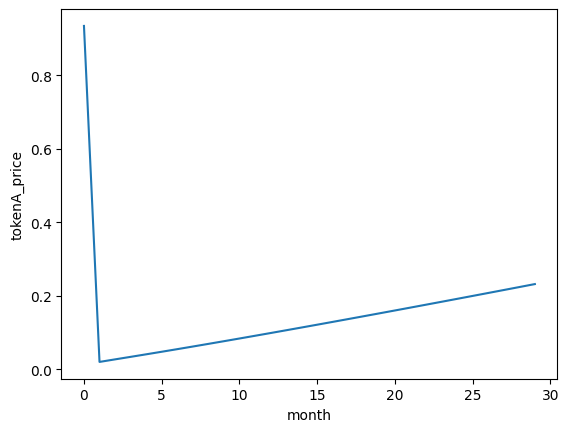

In [7]:
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# Custom functions for conditions

We can also develop custom condition functions. We will now create a custom function that replicates the following logic:

1. There is 10% probability probability of the condition being activated randomly.
2. If the number of users is higher than 10k, but lower than 20k, then the condition is active.

In [21]:
def condition_function(x):
    value=(x[0]>10000) & (x[0]<20000)
    if np.random.rand()>0.1:
        return True
    else:
        return value
    
    

In [22]:
con1=Condition(variables=['num_users'],condition=condition_function)

In [23]:
usm_fiat=UserGrowth_Spaced(100,20000,ITERATIONS,log_saturated_space)
ap_fiat=AgentPool_Basic(usm_fiat,1000,currency='$')

usm_conditional=UserGrowth_Spaced(100,20000,ITERATIONS,log_saturated_space)
ap_conditional=AgentPool_Conditional(users_controller=usm_conditional,currency='$',connect_to_token_economy=True)
ap_conditional.add_condition(con1,TransactionManagement_Constant(200))

te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat,ap_conditional])

True

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 475.84it/s]


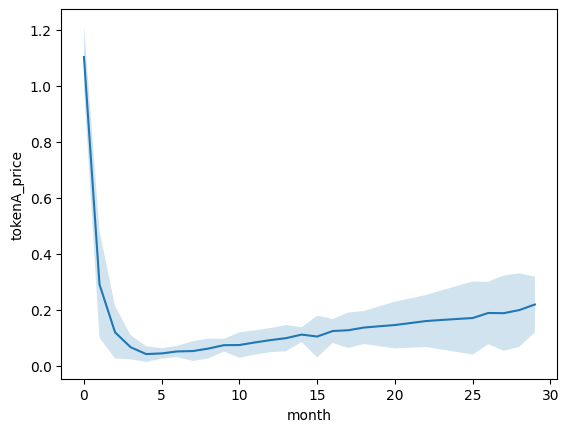

In [24]:
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot